# Demo: previsão de séries temporais multivariadas

Na seção anterior, vimos como treinar uma rede neural convolucional unidimensional sobre uma série temporal univariada, i.e., consideramos que uma única feature era observada a cada passo de tempo. Nesta seção, vamos desenvolver um modelo de rede neural convolucional unidimensional mais genérico, que utiliza todas as dezenove as features do conjunto de dados [Jena Climate](https://www.kaggle.com/datasets/mnassrib/jena-climate).

In [66]:
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests, zipfile, io
import matplotlib.pyplot as plt
import os

In [67]:
zip_file_url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'

r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [68]:
df = pd.read_csv('jena_climate_2009_2016.csv')
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

## Preparação dos dados

### Transformação/criação de variáveis (*feature engineering*)

#### Velocidade do vento

In [69]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

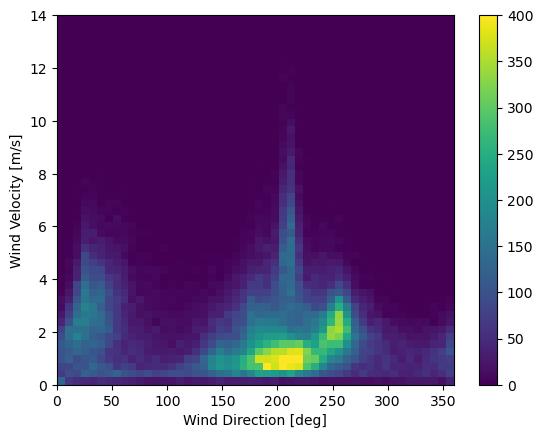

In [70]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [71]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

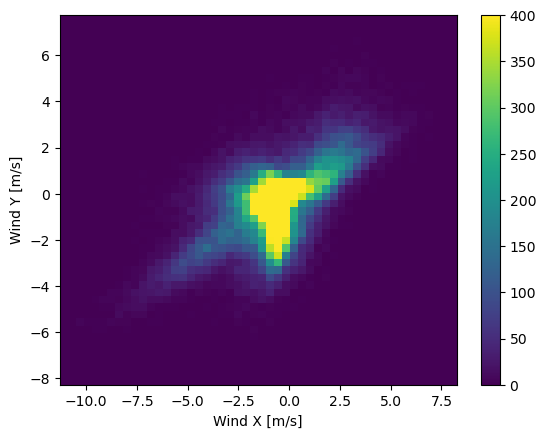

In [72]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Variáveis cíclicas

In [73]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [74]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

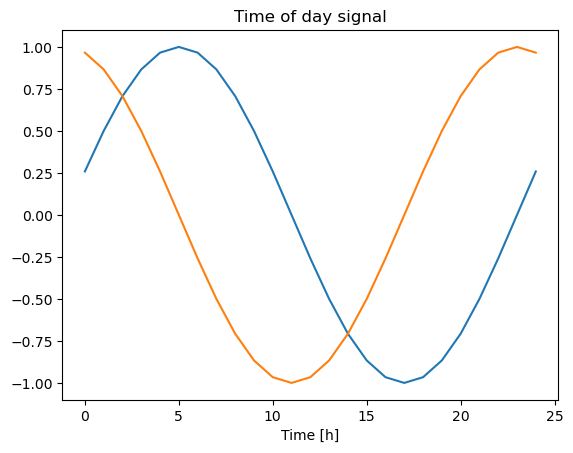

In [75]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

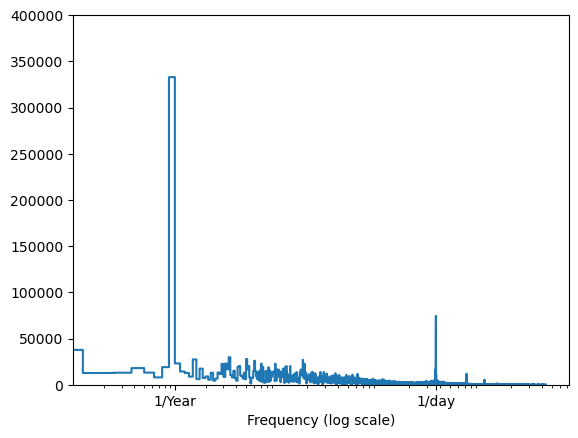

In [76]:
fft = np.fft.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Divisão: treino, validação, teste

Agora dividimos os dados usando a seguinte proporção:

- 70% para treinamento
- 20% para validação
- 10% para teste

Observe que os dados não estão sendo embaralhados aleatoriamente antes da divisão. Isso por dois motivos:

- Garante que ainda é possível separar os dados em janelas de amostras consecutivas.
- Garante que os resultados da validação/teste sejam mais realistas, sendo avaliados nos dados coletados após o treinamento do modelo.

In [77]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(49063, 19)
(14018, 19)
(7010, 19)


### Normalização dos dados

É importante padronizar as faixas de valores das features antes de treinar uma rede neural. A *normalização* é uma maneira comum de fazer essa escala: subtrair a média e dividir pelo desvio padrão de cada feature.

A média e o desvio padrão só devem ser calculados usando os dados de treinamento para que os modelos não tenham acesso aos valores nos conjuntos de validação e teste.

In [78]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Agora, vamos dar uma olhada na distribuição das features. No gráfico que apresenta várias [tramas de violino](https://en.wikipedia.org/wiki/Violin_plot) produzido pelo bloco de código abaixo, podemos ver que algumas features têm caudas longas, mas não há erros óbvios como o valor  -9999 encontrado na velocidade do vento.

In [ ]:
import seaborn as sns
# Para evitar viés na análise, usamos apenas o conjunto de treino nesta visualização.
df_std = (train_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_df.keys(), rotation=90)


### Janelamento (*data windowing*)


In [80]:
train_arr = np.array(train_df)
val_arr = np.array(val_df)
test_arr = np.array(test_df)
print(train_arr.shape)
print(val_arr.shape)
print(test_arr.shape)


(49063, 19)
(14018, 19)
(7010, 19)


In [81]:
import numpy as np
import pandas as pd

def window_generator_multi(sequence, n_steps):
    x, y = list(), list()
    
    for i in range(len(sequence) - n_steps):
        seq_x, seq_y = sequence[i:i + n_steps], sequence[i + n_steps]
        x.append(seq_x)
        y.append(seq_y)
    
    x_df = pd.DataFrame(np.array(x).reshape(len(x), -1))
    y_df = pd.DataFrame(np.array(y))
    
    return x_df, y_df

# Exemplo de uso para uma série bivariada
sequence = np.array([
    [1, 10],
    [2, 20],
    [3, 30],
    [4, 40],
    [5, 50],
    [6, 60]
])

n_steps = 2
x, y = window_generator_multi(sequence, n_steps)
print("X:")
print(x)
print("Y:")
print(y)

X:
   0   1  2   3
0  1  10  2  20
1  2  20  3  30
2  3  30  4  40
3  4  40  5  50
Y:
   0   1
0  3  30
1  4  40
2  5  50
3  6  60


Créditos: o bloco de código abaixo é baseado no encontrado [aqui](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [82]:
def apply_windowing(X, initial_time_step, max_time_step, window_size, idx_target):

  assert idx_target >= 0 and idx_target < X.shape[1]
  assert initial_time_step >= 0
  assert max_time_step >= initial_time_step

  start = initial_time_step
    
  sub_windows = (
        start +
        # expand_dims converts a 1D array to 2D array.
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(max_time_step + 1), 0).T
  )
    
  return X[sub_windows], X[window_size:(max_time_step+window_size+1):1, idx_target]

In [ ]:
TIME_WINDOW_SIZE = 3
IDX_TARGET = 1 # index of column 'T (degC)' is 1

# Treino: janelas estritamente dentro do conjunto de treino
train_x, train_y = apply_windowing(train_arr,
                                  initial_time_step=0,
                                  max_time_step=len(train_arr)-TIME_WINDOW_SIZE-1,
                                  window_size=TIME_WINDOW_SIZE,
                                  idx_target=IDX_TARGET)
train_y = train_y.reshape(-1, 1)
print(train_x.shape)
print(train_y.shape)

# Validação: usa contexto final do treino para primeiras previsões de validação
val_input = np.concatenate([train_arr[-TIME_WINDOW_SIZE:], val_arr], axis=0)
val_x, val_y = apply_windowing(val_input,
                              initial_time_step=0,
                              max_time_step=len(val_input)-TIME_WINDOW_SIZE-1,
                              window_size=TIME_WINDOW_SIZE,
                              idx_target=IDX_TARGET)
val_y = val_y.reshape(-1, 1)
print(val_x.shape)
print(val_y.shape)

# Teste: usa contexto final da validação para primeiras previsões de teste
test_input = np.concatenate([val_arr[-TIME_WINDOW_SIZE:], test_arr], axis=0)
test_x, test_y = apply_windowing(test_input,
                                initial_time_step=0,
                                max_time_step=len(test_input)-TIME_WINDOW_SIZE-1,
                                window_size=TIME_WINDOW_SIZE,
                                idx_target=IDX_TARGET)
test_y = test_y.reshape(-1, 1)
print(test_x.shape)
print(test_y.shape)


O PyTorch espera que cada tensor usado no treinamento tenha a forma `[batch, channels_in, time]`. Em particular, a dimensão das features `channels_in` deve ser a central nos tensores. Sendo assim, o código abaixo usa a função `permute` para pivotear (reposicionar) a ordem das dimensões dentro de cada tensor: as posições das dimensões originais 0, 1 e 2 são trocadas para as posições 0, 2 e 1.

In [84]:
train_x = torch.from_numpy(train_x)
train_x = torch.permute(train_x, (0, 2, 1))
train_y = torch.from_numpy(train_y)
print(train_x.shape)
print(train_y.shape)

val_x = torch.from_numpy(val_x)
val_x = torch.permute(val_x, (0, 2, 1))
val_y = torch.from_numpy(val_y)
print(val_x.shape)
print(val_y.shape)

test_x = torch.from_numpy(test_x)
test_x = torch.permute(test_x, (0, 2, 1))
test_y = torch.from_numpy(test_y)
print(test_x.shape)
print(test_y.shape)

torch.Size([49060, 19, 3])
torch.Size([49060, 1])
torch.Size([14015, 19, 3])
torch.Size([14015, 1])
torch.Size([7007, 19, 3])
torch.Size([7007, 1])


In [85]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(train_x, train_y)
val_ds = TensorDataset(val_x, val_y)
test_ds = TensorDataset(test_x, test_y)

BATCH_SIZE = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

### Treinamento do modelo

In [86]:
# %load net.py
class Net(nn.Module):
    def __init__(self, in_channels, input_length):
        super(Net, self).__init__()
        self.conv1d = nn.Conv1d(in_channels, 64, kernel_size=3)
        self.relu = nn.ReLU()
        
        # Compute the output length after the Conv1d layer
        # Assuming no padding and stride of 1
        conv_out_length = input_length - 3 + 1  # Length after applying kernel_size=3
        self.fc1 = nn.Linear(64 * conv_out_length, 50)  # Adjusted the input size for fc1
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(x.shape[0], -1)  # Flattening the output
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [87]:
# %load device_dataloader.py
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

model = Net(in_channels=19, input_length=3)
model = model.to(device=device, dtype=torch.float32)

cpu


In [89]:
print(model)

Net(
  (conv1d): Conv1d(19, 64, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


Apenas para fins de inspeção, o bloco de código a seguir imprime as dimensões do tensor correspondente ao primeiro lote de treinamento.

In [90]:
for xb, yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 19, 3])
torch.Size([32, 1])


In [ ]:
# %load fit.py
def fit(epochs, lr, model, train_dl, val_dl, criterion, optimizer):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = optimizer(model.parameters(), lr)
    for epoch in range(epochs):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data, target in train_dl:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the loss
            loss = criterion(output, target.float())
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        with torch.no_grad():
            for data, target in val_dl:
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data.float())
                # calculate the loss
                loss = criterion(output, target.float())
                # record validation loss
                valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
  
    return  model, avg_train_losses, avg_valid_losses


In [92]:
n_epochs = 50
n_epochs = 30
lr = 1e-5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam

model, train_loss, val_loss = fit(n_epochs, lr, model, train_dl, val_dl, criterion, optimizer)

[ 0/30] train_loss: 0.73850 valid_loss: 0.36259
[ 1/30] train_loss: 0.30863 valid_loss: 0.09352
[ 2/30] train_loss: 0.08720 valid_loss: 0.03722
[ 3/30] train_loss: 0.04051 valid_loss: 0.02692
[ 4/30] train_loss: 0.02829 valid_loss: 0.02084
[ 5/30] train_loss: 0.02236 valid_loss: 0.01789
[ 6/30] train_loss: 0.01907 valid_loss: 0.01622
[ 7/30] train_loss: 0.01703 valid_loss: 0.01499
[ 8/30] train_loss: 0.01552 valid_loss: 0.01398
[ 9/30] train_loss: 0.01434 valid_loss: 0.01312
[10/30] train_loss: 0.01341 valid_loss: 0.01241
[11/30] train_loss: 0.01265 valid_loss: 0.01180
[12/30] train_loss: 0.01201 valid_loss: 0.01126
[13/30] train_loss: 0.01146 valid_loss: 0.01080
[14/30] train_loss: 0.01098 valid_loss: 0.01039
[15/30] train_loss: 0.01055 valid_loss: 0.01003
[16/30] train_loss: 0.01017 valid_loss: 0.00972
[17/30] train_loss: 0.00983 valid_loss: 0.00943
[18/30] train_loss: 0.00953 valid_loss: 0.00917
[19/30] train_loss: 0.00927 valid_loss: 0.00894
[20/30] train_loss: 0.00903 valid_loss: 

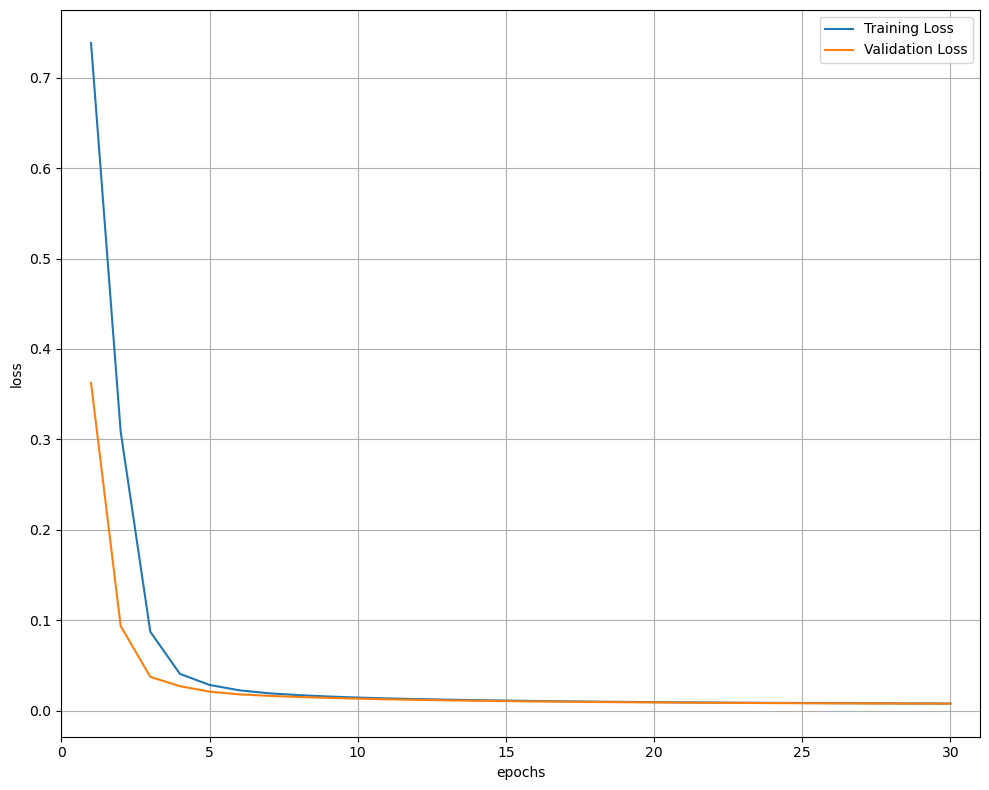

In [93]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

### Avaliação no conjunto de teste

Para análise de regressão, vamos comparar valores previstos e esperados no conjunto de teste, incluindo métricas e visualizações.


In [94]:
# Inferência no teste (normalizado)
model.eval()
y_true_batches = []
y_pred_batches = []

with torch.no_grad():
    for data, target in test_dl:
        pred = model(data.float())
        y_true_batches.append(target.detach().cpu().numpy())
        y_pred_batches.append(pred.detach().cpu().numpy())

y_true_norm = np.concatenate(y_true_batches).reshape(-1)
y_pred_norm = np.concatenate(y_pred_batches).reshape(-1)

# Desnormalização da variável-alvo
target_col = df.columns[IDX_TARGET]
target_mean = train_mean[target_col]
target_std = train_std[target_col]

y_true = y_true_norm * target_std + target_mean
y_pred = y_pred_norm * target_std + target_mean

# Métricas no teste
mse_test = np.mean((y_true - y_pred) ** 2)
rmse_test = np.sqrt(mse_test)
mae_test = np.mean(np.abs(y_true - y_pred))

print(f'Target: {target_col}')
print(f'Test MSE:  {mse_test:.6f}')
print(f'Test RMSE: {rmse_test:.6f}')
print(f'Test MAE:  {mae_test:.6f}')


Target: T (degC)
Test MSE:  0.553996
Test RMSE: 0.744309
Test MAE:  0.541770


#### Plot: previsto vs esperado


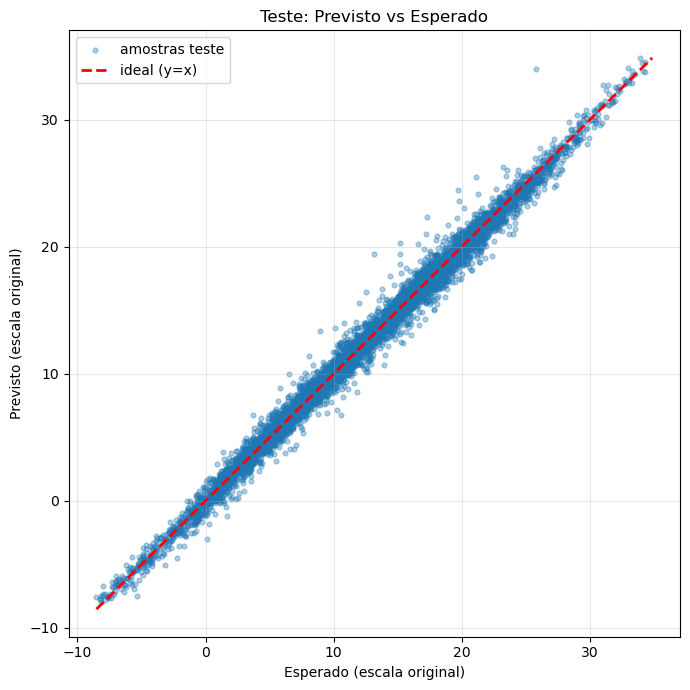

In [95]:
plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, alpha=0.35, s=12, label='amostras teste')
line_min = min(np.min(y_true), np.min(y_pred))
line_max = max(np.max(y_true), np.max(y_pred))
plt.plot([line_min, line_max], [line_min, line_max], 'r--', linewidth=2, label='ideal (y=x)')
plt.xlabel('Esperado (escala original)')
plt.ylabel('Previsto (escala original)')
plt.title('Teste: Previsto vs Esperado')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


#### Plot: séries temporais esperado vs previsto


In [ ]:
# Índice temporal correspondente aos alvos no conjunto de teste
test_time_index = test_df.index[:len(y_true)]

plt.figure(figsize=(14, 5))
plt.plot(test_time_index, y_true, label='Esperado', linewidth=1.5)
plt.plot(test_time_index, y_pred, label='Previsto', linewidth=1.2, alpha=0.85)
plt.title('Série temporal no teste (completo)')
plt.xlabel('Índice temporal')
plt.ylabel(target_col)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom nas primeiras amostras
zoom_n = min(300, len(y_true))
plt.figure(figsize=(14, 5))
plt.plot(test_time_index[:zoom_n], y_true[:zoom_n], label='Esperado', linewidth=1.8)
plt.plot(test_time_index[:zoom_n], y_pred[:zoom_n], label='Previsto', linewidth=1.4, alpha=0.9)
plt.title(f'Série temporal no teste (zoom: primeiras {zoom_n} amostras)')
plt.xlabel('Índice temporal')
plt.ylabel(target_col)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Referências

- [4 Strategies for Multi-Step Time Series Forecasting](https://machinelearningmastery.com/multi-step-time-series-forecasting/)

- [Time Series One Step Ahead vs N-Step Ahead](https://stats.stackexchange.com/questions/342392/time-series-one-step-ahead-vs-n-step-ahead)

- [How to Train Your Neural Net](https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29)

- [How to Develop Convolutional Neural Network Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting)

- [What does the "No Free Lunch" theorem mean for machine learning? In what ways do popular ML algorithms overcome the limitations set by this theorem?](https://www.quora.com/What-does-the-No-Free-Lunch-theorem-mean-for-machine-learning-In-what-ways-do-popular-ML-algorithms-overcome-the-limitations-set-by-this-theorem)

- [How to Decompose Time Series Data into Trend and Seasonality](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

- [Time Series Prediction using LSTM with PyTorch in Python](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python)

- [Time series forecasting](www.tensorflow.org/tutorials/structured_data/time_series)

- [Demand forecasting with the Temporal Fusion Transformer](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html#Evaluate-performance)

- [PyTorch Performance Analysis with TensorBoard](https://towardsdatascience.com/pytorch-performance-analysis-with-tensorboard-7c61f91071aa)

- [Introducing PyTorch Forecasting](https://towardsdatascience.com/introducing-pytorch-forecasting-64de99b9ef46)

- [Time Series Analysis in Python – A Comprehensive Guide with Examples](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)

- [Learning Spatiotemporal Features with 3D Convolutional Networks](https://arxiv.org/abs/1412.0767)

- [Introduction to Machine Learning with Time Series || Markus Loning](https://youtu.be/wqQKFu41FIw)

